In [1]:
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve,
                            confusion_matrix, classification_report, 
                            brier_score_loss, log_loss, average_precision_score)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 1. Load Cleaned Data

In [4]:
app_train = pd.read_csv('./Dataset/application_train_cleaned.csv')
app_test = pd.read_csv('./Dataset/application_test_cleaned.csv')

In [5]:
app_train.shape

(307511, 190)

In [6]:
app_test.shape

(48744, 189)

In [7]:
app_train['TARGET'].value_counts(normalize=True)

TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

# 2. Data Preparation

In [9]:
def prepare_data_for_modeling(train_df, test_df):

    # Separate features and target
    y = train_df["TARGET"]

    # Remove ID and target columns
    feature_cols = [col for col in train_df.columns if col not in ["SK_ID_CURR", "TARGET"]]

    X_train = train_df[feature_cols].copy()
    X_test = test_df[feature_cols].copy() if 'TARGET' not in test_df.columns else test_df[feature_cols].copy()

    # Handle categorical variables
    categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

    # Label encoding for categorical varaiables
    label_encoders = {}
    for col in categorical_cols:
        le = LabelEncoder()
        combined = pd.concat([X_train[col].astype(str), X_test[col].astype(str)])
        le.fit(combined)
        X_train[col] = le.transform(X_train[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
        label_encoders[col] = le

    # Handle any remaining missing values
    X_train = X_train.fillna(X_train.median())
    X_test = X_test.fillna(X_train.median())

    X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())
    X_test = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_train.median())

    print(f"Final feature count: {X_train.shape[1]}")
    print(f"Training samples: {X_train.shape[0]}")
    
    return X_train, X_test, y, feature_cols, label_encoders

In [10]:
X, X_test_final, y, feature_cols, label_encoders = prepare_data_for_modeling(app_train, app_test)

Final feature count: 188
Training samples: 307511


In [11]:
# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
sk_ids = app_train['SK_ID_CURR'].values
sk_ids_train, sk_ids_val = train_test_split(sk_ids, test_size=0.2, random_state=42, stratify=y)

In [13]:
print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Positive rate (train): {y_train.mean():.4f}")
print(f"Positive rate (val): {y_val.mean():.4f}")


Train set: 246008 samples
Validation set: 61503 samples
Positive rate (train): 0.0807
Positive rate (val): 0.0807


# 3. Model Selection Rationale
## Why These Models?

**1. Logistic Regression (Baseline)**
- Simple, interpretable model that outputs well-calibrated probabilities by default
- Serves as a baseline for comparing more complex models
- Good for understanding feature coefficients

**2. LightGBM (Primary Model)**
- State-of-the-art gradient boosting algorithm, highly effective for tabular data
- Fast training speed and low memory usage
- Handles categorical features naturally
- Excellent performance on imbalanced datasets with appropriate settings

**3. Gradient Boosting Classifier**
- Another ensemble method for comparison
- More conservative/slower than LightGBM but can provide insights

## Why PD(Probability of Default) is more valuable than a binary label
- **Risk-based pricing:** With a PD for each customer, lenders can price by risk tier: high PD -> higher interset/fees to cover expected losses and capital usage; lower PD -> more favorable pricing to attract prime borrowers
- **Portfolio risk assessment:** At the portfolio level, expected loss aggregates as`EL = PD * LGD * EAD` loan by loan. Continuous probabilities (not 0/1) enable granular exposure measurement, scenario analysis, stress testing, and capital planning
- **Flexible decision trhresholds:** With probability outputs, business teams can set dynamic cutoffs/segments (e.g., p ≥ 0.25: decline, 0.10–0.25: manual review, p < 0.10: approve) and adjust them over time as market conditions, budget, or capacity change—without retraining the model

# 4. Model Training

## 4.1 Train Logistic Regression

In [17]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [18]:
# Train Logistic Regression
lr_model = LogisticRegression(
    random_state=42, 
    max_iter=1000,
    class_weight='balanced',  # Handle class imbalance
    solver='lbfgs'
)
lr_model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [19]:
# Get probability predictions
y_pred_proba_lr = lr_model.predict_proba(X_val_scaled)[:, 1]

In [20]:
print("Logistic Regression Results:")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba_lr):.4f}")
print(f"Brier Score: {brier_score_loss(y_val, y_pred_proba_lr):.4f}")
print(f"Log Loss: {log_loss(y_val, y_pred_proba_lr):.4f}")

Logistic Regression Results:
ROC-AUC: 0.7616
Brier Score: 0.1983
Log Loss: 0.5817


## 4.2 Train LightGBM Model

In [22]:
# LightGBM parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_child_samples': 100,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'is_unbalance': True, 
    'random_state': 42,
    'n_jobs': -1,
    'verbosity': -1
}

In [23]:
# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

In [24]:
# Train with early stopping
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ]
)

Training until validation scores don't improve for 50 rounds
[100]	train's auc: 0.790216	valid's auc: 0.769759
[200]	train's auc: 0.812523	valid's auc: 0.775894
[300]	train's auc: 0.829741	valid's auc: 0.777326
[400]	train's auc: 0.845141	valid's auc: 0.778065
[500]	train's auc: 0.858654	valid's auc: 0.77851
Early stopping, best iteration is:
[527]	train's auc: 0.862208	valid's auc: 0.778672


In [25]:
# Get probability predictions
y_pred_proba_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

In [26]:
print("\nLightGBM Results:")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba_lgb):.4f}")
print(f"Brier Score: {brier_score_loss(y_val, y_pred_proba_lgb):.4f}")
print(f"Log Loss: {log_loss(y_val, y_pred_proba_lgb):.4f}")
print(f"Best iteration: {lgb_model.best_iteration}")


LightGBM Results:
ROC-AUC: 0.7787
Brier Score: 0.1715
Log Loss: 0.5133
Best iteration: 527


## 4.3 Model Comparison Summary

In [28]:
# Create comparison DataFrame
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'LightGBM'],
    'ROC-AUC': [roc_auc_score(y_val, y_pred_proba_lr), 
                roc_auc_score(y_val, y_pred_proba_lgb)],
    'Brier Score': [brier_score_loss(y_val, y_pred_proba_lr),
                    brier_score_loss(y_val, y_pred_proba_lgb)],
    'Log Loss': [log_loss(y_val, y_pred_proba_lr),
                 log_loss(y_val, y_pred_proba_lgb)],
    'Average Precision': [average_precision_score(y_val, y_pred_proba_lr),
                          average_precision_score(y_val, y_pred_proba_lgb)]
})

model_comparison

,Model,ROC-AUC,Brier Score,Log Loss,Average Precision
0,Logistic Regression,0.761612,0.198349,0.581694,0.246771
1,LightGBM,0.778672,0.171533,0.513286,0.274129


**Conclusion:** LightGBM model is better based on the indicators.

# 5. Probability Calibration

In [31]:
# Apply Isotonic calibration to LightGBM
calibrated_lgb = CalibratedClassifierCV(
    lgb.LGBMClassifier(**{k: v for k, v in lgb_params.items() 
                          if k not in ['metric', 'verbosity']}),
    method='isotonic',
    cv=3
)
calibrated_lgb.fit(X_train, y_train)
y_pred_proba_calibrated = calibrated_lgb.predict_proba(X_val)[:, 1]

print("Calibrated LightGBM Results:")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_proba_calibrated):.4f}")
print(f"Brier Score: {brier_score_loss(y_val, y_pred_proba_calibrated):.4f}")
print(f"Log Loss: {log_loss(y_val, y_pred_proba_calibrated):.4f}")

Calibrated LightGBM Results:
ROC-AUC: 0.7713
Brier Score: 0.0669
Log Loss: 0.2419


In [32]:
# ----------------------------------------------------------
# EXPORT VALIDATION RESULTS FOR POWER BI
# ----------------------------------------------------------
import pandas as pd

validation_results = pd.DataFrame({
    "SK_ID_CURR": sk_ids_val,
    "TARGET": y_val,
    "PD": y_pred_proba_calibrated
})

# Add model credit score if your function exists
try:
    validation_results["Credit_Score"] = pd_to_credit_score(validation_results["PD"])
except:
    pass

# Save CSV
validation_results.to_csv("./Dataset/validation_results.csv", index=False)

validation_results.head()


,SK_ID_CURR,TARGET,PD
256571,396899,0,0.049241
191493,322041,0,0.055356
103497,220127,0,0.250606
130646,251531,0,0.091780
211898,345558,0,0.108057


In [33]:
# Compare calibration before and after
print(f"{'Metric':<20} {'Before':<15} {'After':<15} {'Improvement'}")
print("-"*60)

brier_before = brier_score_loss(y_val, y_pred_proba_lgb)
brier_after = brier_score_loss(y_val, y_pred_proba_calibrated)
print(f"{'Brier Score':<20} {brier_before:<15.4f} {brier_after:<15.4f} {(brier_before-brier_after)/brier_before*100:+.2f}%")

logloss_before = log_loss(y_val, y_pred_proba_lgb)
logloss_after = log_loss(y_val, y_pred_proba_calibrated)
print(f"{'Log Loss':<20} {logloss_before:<15.4f} {logloss_after:<15.4f} {(logloss_before-logloss_after)/logloss_before*100:+.2f}%")


Metric               Before          After           Improvement
------------------------------------------------------------
Brier Score          0.1715          0.0669          +61.02%
Log Loss             0.5133          0.2419          +52.87%


# 6. Visualization

## 6.1 ROC Curves Comparison

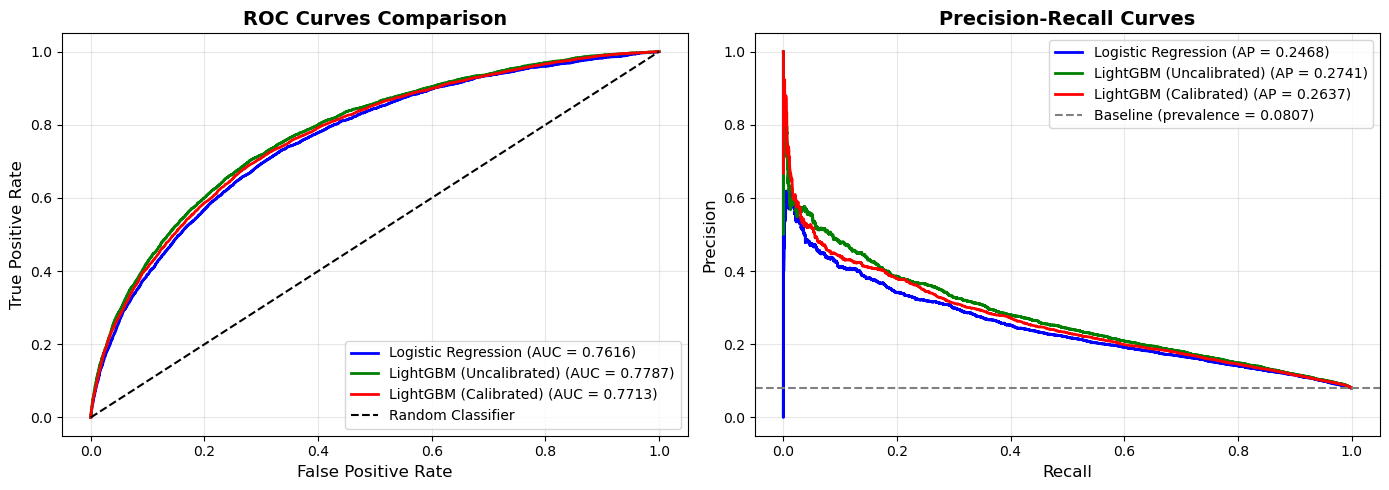

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
ax1 = axes[0]
for name, y_proba, color in [
    ('Logistic Regression', y_pred_proba_lr, 'blue'),
    ('LightGBM (Uncalibrated)', y_pred_proba_lgb, 'green'),
    ('LightGBM (Calibrated)', y_pred_proba_calibrated, 'red')
]:
    fpr, tpr, _ = roc_curve(y_val, y_proba)
    auc = roc_auc_score(y_val, y_proba)
    ax1.plot(fpr, tpr, color=color, label=f'{name} (AUC = {auc:.4f})', linewidth=2)

ax1.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Precision-Recall Curves
ax2 = axes[1]
for name, y_proba, color in [
    ('Logistic Regression', y_pred_proba_lr, 'blue'),
    ('LightGBM (Uncalibrated)', y_pred_proba_lgb, 'green'),
    ('LightGBM (Calibrated)', y_pred_proba_calibrated, 'red')
]:
    precision, recall, _ = precision_recall_curve(y_val, y_proba)
    ap = average_precision_score(y_val, y_proba)
    ax2.plot(recall, precision, color=color, label=f'{name} (AP = {ap:.4f})', linewidth=2)

ax2.axhline(y=y_val.mean(), color='gray', linestyle='--', label=f'Baseline (prevalence = {y_val.mean():.4f})')
ax2.set_xlabel('Recall', fontsize=12)
ax2.set_ylabel('Precision', fontsize=12)
ax2.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6.2 Feature Importance (Top 20)

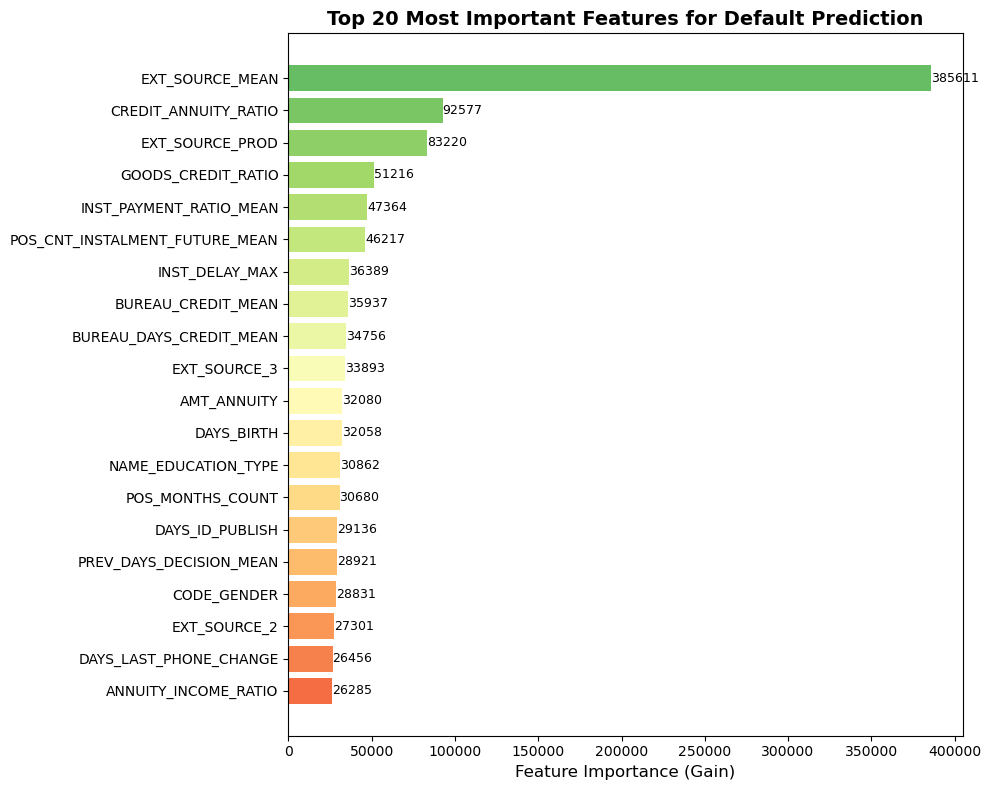

In [38]:
# Get feature importance from LightGBM
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Plot top 20 features
fig, ax = plt.subplots(figsize=(10, 8))

top_20 = feature_importance.head(20)
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, 20))

bars = ax.barh(range(len(top_20)), top_20['importance'], color=colors)
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['feature'])
ax.invert_yaxis()
ax.set_xlabel('Feature Importance (Gain)', fontsize=12)
ax.set_title('Top 20 Most Important Features for Default Prediction', fontsize=14, fontweight='bold')

# Add importance values
for i, (bar, val) in enumerate(zip(bars, top_20['importance'])):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.0f}', 
            va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 6.3 Calibration Plot

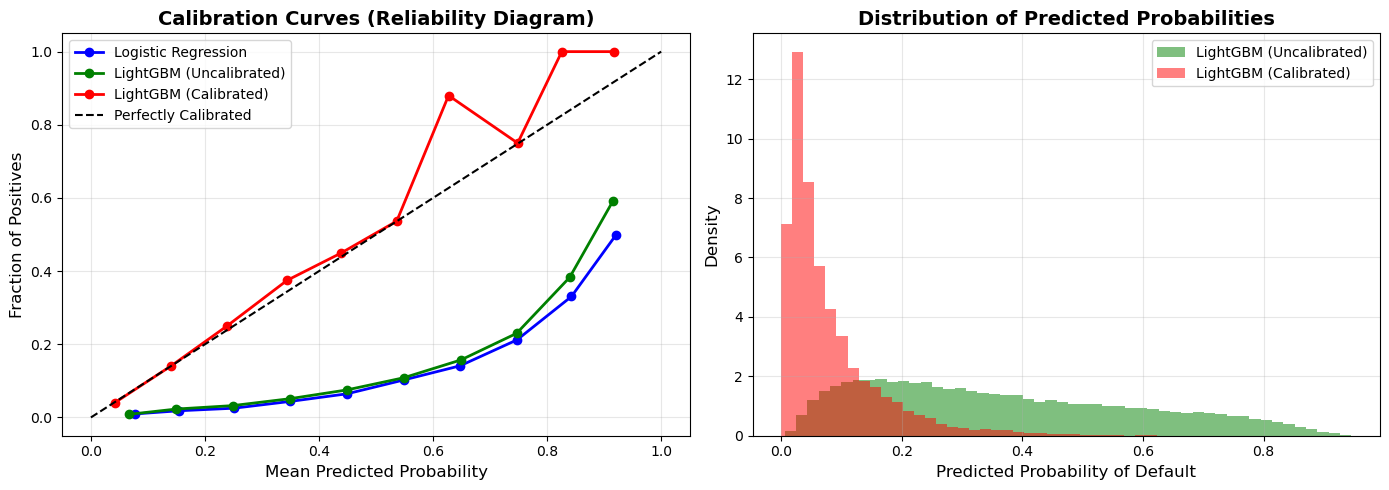

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Calibration curves
ax1 = axes[0]
for name, y_proba, color, style in [
    ('Logistic Regression', y_pred_proba_lr, 'blue', '-'),
    ('LightGBM (Uncalibrated)', y_pred_proba_lgb, 'green', '-'),
    ('LightGBM (Calibrated)', y_pred_proba_calibrated, 'red', '-')
]:
    prob_true, prob_pred = calibration_curve(y_val, y_proba, n_bins=10, strategy='uniform')
    ax1.plot(prob_pred, prob_true, color=color, marker='o', linestyle=style, 
             label=name, linewidth=2, markersize=6)

ax1.plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
ax1.set_xlabel('Mean Predicted Probability', fontsize=12)
ax1.set_ylabel('Fraction of Positives', fontsize=12)
ax1.set_title('Calibration Curves (Reliability Diagram)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Distribution of predicted probabilities
ax2 = axes[1]
for name, y_proba, color in [
    ('LightGBM (Uncalibrated)', y_pred_proba_lgb, 'green'),
    ('LightGBM (Calibrated)', y_pred_proba_calibrated, 'red')
]:
    ax2.hist(y_proba, bins=50, alpha=0.5, color=color, label=name, density=True)

ax2.set_xlabel('Predicted Probability of Default', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Distribution of Predicted Probabilities', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6.4 Confusion Matrix at Different Thresholds

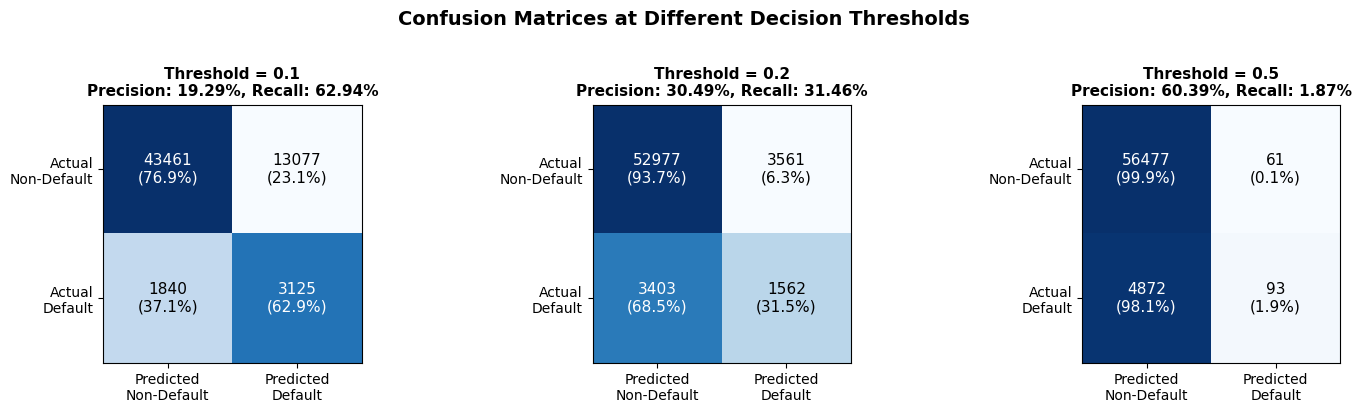

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

thresholds = [0.1, 0.2, 0.5]
y_proba = y_pred_proba_calibrated

for idx, threshold in enumerate(thresholds):
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_val, y_pred)
    
    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    ax = axes[idx]
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues')
    
    for i in range(2):
        for j in range(2):
            text_color = 'white' if cm_normalized[i, j] > 0.5 else 'black'
            ax.text(j, i, f'{cm[i, j]}\n({cm_normalized[i, j]:.1%})', 
                   ha='center', va='center', color=text_color, fontsize=11)
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Predicted\nNon-Default', 'Predicted\nDefault'])
    ax.set_yticklabels(['Actual\nNon-Default', 'Actual\nDefault'])

    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    ax.set_title(f'Threshold = {threshold}\nPrecision: {precision:.2%}, Recall: {recall:.2%}', 
                fontsize=11, fontweight='bold')

plt.suptitle('Confusion Matrices at Different Decision Thresholds', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 6.5 Credit Score Distribution

Convert Probability of Default to a credit score scale similar to FICO (300-850).

**Score Formula:**
$$Score = BaseScore + \frac{PDO}{\ln(2)} \times \ln\left(\frac{1-PD}{PD}\right)$$

Where:
- BaseScore: Score at odds 1:1 (typically 600)
- PDO: Points to Double the Odds (typically 20)

In [44]:
# Credit Score Mapping
def pd_to_credit_score(pd_values, base_score=600, pdo=20, target_odds=1.0):

    # Clip PD to avoid log(0) or log(inf)
    pd_clipped = np.clip(pd_values, 0.001, 0.999)
    
    # Calculate log-odds (odds = (1-PD)/PD for good borrower odds)
    odds = (1 - pd_clipped) / pd_clipped
    
    # Factor for scoring
    factor = pdo / np.log(2)
    
    # Calculate score
    scores = base_score + factor * np.log(odds / target_odds)
    
    # Clip to reasonable range
    return np.clip(scores, 300, 850).astype(int)

# Apply credit score mapping
credit_scores = pd_to_credit_score(y_pred_proba_calibrated)

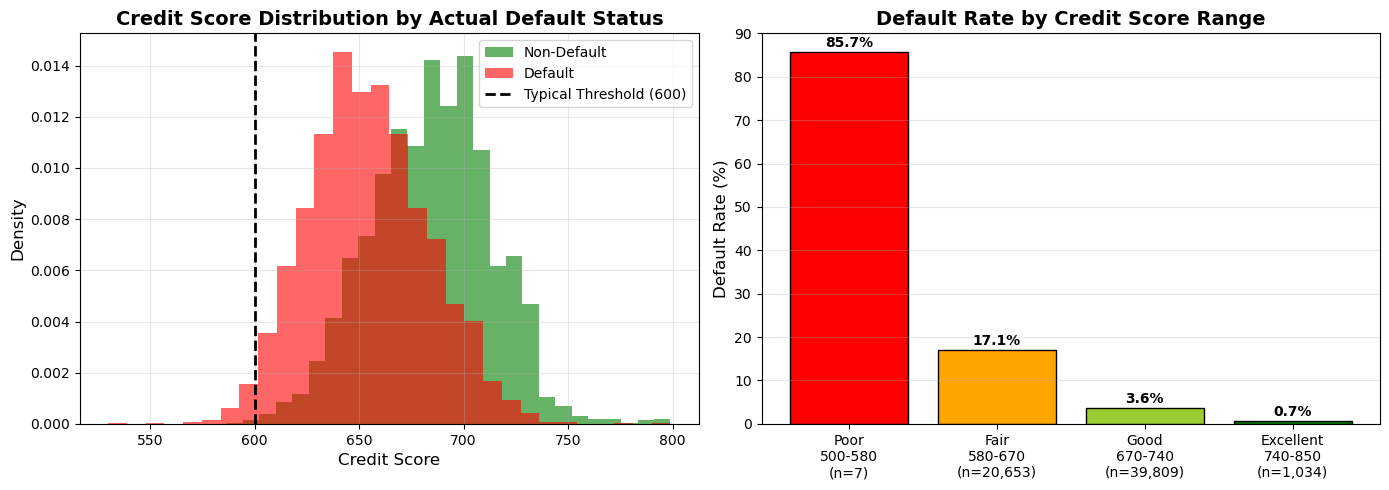

In [45]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Credit score distribution by actual status
ax1 = axes[0]
for label, color, name in [(0, 'green', 'Non-Default'), (1, 'red', 'Default')]:
    mask = y_val == label
    ax1.hist(credit_scores[mask], bins=30, alpha=0.6, color=color, label=name, density=True)

ax1.axvline(x=600, color='black', linestyle='--', linewidth=2, label='Typical Threshold (600)')
ax1.set_xlabel('Credit Score', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Credit Score Distribution by Actual Default Status', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Credit score ranges
ax2 = axes[1]
score_ranges = [
    (300, 500, 'Very Poor', 'darkred'),
    (500, 580, 'Poor', 'red'),
    (580, 670, 'Fair', 'orange'),
    (670, 740, 'Good', 'yellowgreen'),
    (740, 850, 'Excellent', 'green')
]

# Calculate default rate per score range
range_stats = []
for low, high, label, color in score_ranges:
    mask = (credit_scores >= low) & (credit_scores < high)
    if mask.sum() > 0:
        default_rate = y_val.values[mask].mean()
        count = mask.sum()
        range_stats.append({
            'Range': f'{low}-{high}',
            'Label': label,
            'Default Rate': default_rate,
            'Count': count,
            'Color': color
        })

range_df = pd.DataFrame(range_stats)

bars = ax2.bar(range(len(range_df)), range_df['Default Rate'] * 100, 
               color=range_df['Color'], edgecolor='black')
ax2.set_xticks(range(len(range_df)))
ax2.set_xticklabels([f"{r['Label']}\n{r['Range']}\n(n={r['Count']:,})" for _, r in range_df.iterrows()])
ax2.set_ylabel('Default Rate (%)', fontsize=12)
ax2.set_title('Default Rate by Credit Score Range', fontsize=14, fontweight='bold')

# Add percentage labels on bars
for bar, rate in zip(bars, range_df['Default Rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{rate*100:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [46]:
# Create mapping reference table
pd_values = np.array([0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.30, 0.50, 0.70, 0.90])
scores = pd_to_credit_score(pd_values)

mapping_table = pd.DataFrame({
    'Probability of Default (PD)': [f'{p:.0%}' for p in pd_values],
    'Credit Score': scores,
    'Risk Category': ['Excellent', 'Excellent', 'Good', 'Good', 'Fair', 'Fair', 
                      'Poor', 'Very Poor', 'Very Poor', 'Very Poor']
})

mapping_table

,Probability of Default (PD),Credit Score,Risk Category
0,1%,732,Excellent
1,2%,712,Excellent
2,5%,684,Good
3,10%,663,Good
4,15%,650,Fair
5,20%,640,Fair
6,30%,624,Poor
7,50%,600,Very Poor
8,70%,575,Very Poor
9,90%,536,Very Poor


# 7. Final Model

In [48]:
# Best model metrics
print("\nMODEL PERFORMANCE METRICS (Calibrated LightGBM)")
print("-"*50)
print(f"ROC-AUC Score:         {roc_auc_score(y_val, y_pred_proba_calibrated):.4f}")
print(f"Brier Score:           {brier_score_loss(y_val, y_pred_proba_calibrated):.4f}")
print(f"Log Loss:              {log_loss(y_val, y_pred_proba_calibrated):.4f}")
print(f"Average Precision:     {average_precision_score(y_val, y_pred_proba_calibrated):.4f}")

# Probability statistics
print("\nPROBABILITY OF DEFAULT (PD) STATISTICS")
print("-"*50)
print(f"Mean PD:               {y_pred_proba_calibrated.mean():.4f}")
print(f"Median PD:             {np.median(y_pred_proba_calibrated):.4f}")
print(f"Min PD:                {y_pred_proba_calibrated.min():.4f}")
print(f"Max PD:                {y_pred_proba_calibrated.max():.4f}")
print(f"Std PD:                {y_pred_proba_calibrated.std():.4f}")

# Credit score statistics
print("\nCREDIT SCORE STATISTICS")
print("-"*50)
print(f"Mean Score:            {credit_scores.mean():.0f}")
print(f"Median Score:          {np.median(credit_scores):.0f}")
print(f"Min Score:             {credit_scores.min()}")
print(f"Max Score:             {credit_scores.max()}")


MODEL PERFORMANCE METRICS (Calibrated LightGBM)
--------------------------------------------------
ROC-AUC Score:         0.7713
Brier Score:           0.0669
Log Loss:              0.2419
Average Precision:     0.2637

PROBABILITY OF DEFAULT (PD) STATISTICS
--------------------------------------------------
Mean PD:               0.0805
Median PD:             0.0518
Min PD:                0.0000
Max PD:                0.9167
Std PD:                0.0808

CREDIT SCORE STATISTICS
--------------------------------------------------
Mean Score:            682
Median Score:          683
Min Score:             530
Max Score:             799


# 8. Feature Engineering Impact Analysis

## 8.1 Engineered Features vs Original Features

In [51]:
# Define which features were created during feature engineering
engineered_features = [
    # Ratio features
    'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO', 'CREDIT_ANNUITY_RATIO', 'GOODS_CREDIT_RATIO',
    # Time features
    'AGE_YEARS', 'EMPLOYED_YEARS', 'EMPLOYED_AGE_RATIO',
    # EXT_SOURCE combinations
    'EXT_SOURCE_MEAN', 'EXT_SOURCE_PROD',
    # Income/family features
    'INCOME_PER_FAMILY', 'INCOME_PER_CHILD',
    # Log transformations
    'AMT_INCOME_TOTAL_LOG', 'AMT_CREDIT_LOG', 'AMT_ANNUITY_LOG', 'AMT_GOODS_PRICE_LOG'
]

In [52]:
# Get original features (exclude engineered ones)
original_features = [col for col in feature_cols if col not in engineered_features]

## 8.2 Model Training: Without Feature Engineering

In [54]:
# Prepare data WITHOUT engineered features
X_train_original = X_train[original_features]
X_val_original = X_val[original_features]

# Train LightGBM without FE
lgb_train_orig = lgb.Dataset(X_train_original, label=y_train)
lgb_val_orig = lgb.Dataset(X_val_original, label=y_val, reference=lgb_train_orig)

lgb_model_no_fe = lgb.train(
    lgb_params,
    lgb_train_orig,
    num_boost_round=1000,
    valid_sets=[lgb_train_orig, lgb_val_orig],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=200)
    ]
)

# Predictions without FE
y_pred_no_fe = lgb_model_no_fe.predict(X_val_original, num_iteration=lgb_model_no_fe.best_iteration)

print(f"\nModel WITHOUT Feature Engineering:")
print(f"Best iteration: {lgb_model_no_fe.best_iteration}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_no_fe):.4f}")

Training until validation scores don't improve for 50 rounds
[200]	train's auc: 0.807835	valid's auc: 0.771916
[400]	train's auc: 0.839888	valid's auc: 0.774122
Early stopping, best iteration is:
[441]	train's auc: 0.845652	valid's auc: 0.774371

Model WITHOUT Feature Engineering:
Best iteration: 441
ROC-AUC: 0.7744


## 8.3 Model Training: With Feature Engineering

In [56]:
# Train LightGBM WITH all features (already done, but retrain for fair comparison)
lgb_train_fe = lgb.Dataset(X_train, label=y_train)
lgb_val_fe = lgb.Dataset(X_val, label=y_val, reference=lgb_train_fe)

lgb_model_with_fe = lgb.train(
    lgb_params,
    lgb_train_fe,
    num_boost_round=1000,
    valid_sets=[lgb_train_fe, lgb_val_fe],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=200)
    ]
)

# Predictions with FE
y_pred_with_fe = lgb_model_with_fe.predict(X_val, num_iteration=lgb_model_with_fe.best_iteration)

print(f"\nModel WITH Feature Engineering:")
print(f"Best iteration: {lgb_model_with_fe.best_iteration}")
print(f"ROC-AUC: {roc_auc_score(y_val, y_pred_with_fe):.4f}")

Training until validation scores don't improve for 50 rounds
[200]	train's auc: 0.812523	valid's auc: 0.775894
[400]	train's auc: 0.845141	valid's auc: 0.778065
Early stopping, best iteration is:
[527]	train's auc: 0.862208	valid's auc: 0.778672

Model WITH Feature Engineering:
Best iteration: 527
ROC-AUC: 0.7787


## 8.4 Performance Comparison

In [58]:
# Calculate all metrics
metrics_no_fe = {
    'ROC-AUC': roc_auc_score(y_val, y_pred_no_fe),
    'Brier Score': brier_score_loss(y_val, y_pred_no_fe),
    'Log Loss': log_loss(y_val, y_pred_no_fe),
    'Avg Precision': average_precision_score(y_val, y_pred_no_fe)
}

metrics_with_fe = {
    'ROC-AUC': roc_auc_score(y_val, y_pred_with_fe),
    'Brier Score': brier_score_loss(y_val, y_pred_with_fe),
    'Log Loss': log_loss(y_val, y_pred_with_fe),
    'Avg Precision': average_precision_score(y_val, y_pred_with_fe)
}

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': list(metrics_no_fe.keys()),
    'Without FE': list(metrics_no_fe.values()),
    'With FE': list(metrics_with_fe.values()),
})

# Calculate improvement
def calc_improvement(metric, before, after):
    diff = after - before
    pct = (diff / before) * 100
    # For Brier and Log Loss, lower is better (negative improvement is good)
    if metric in ['Brier Score', 'Log Loss']:
        return f"{pct:+.2f}%" if diff < 0 else f"{pct:+.2f}%"
    else:
        return f"{pct:+.2f}%"

comparison_df['Improvement'] = [
    calc_improvement(m, comparison_df.loc[i, 'Without FE'], comparison_df.loc[i, 'With FE'])
    for i, m in enumerate(comparison_df['Metric'])
]

print("=" * 70)
print("FEATURE ENGINEERING IMPACT ANALYSIS")
print("=" * 70)
print(f"\nFeatures: {len(original_features)} (original) → {len(feature_cols)} (with FE)")
print(f"New features added: {len(engineered_features)}")
print("\n" + comparison_df.to_string(index=False))
print("\n* For ROC-AUC & Avg Precision: higher is better (positive improvement = good)")
print("* For Brier Score & Log Loss: lower is better (negative improvement = good)")

FEATURE ENGINEERING IMPACT ANALYSIS

Features: 173 (original) → 188 (with FE)
New features added: 15

       Metric  Without FE  With FE Improvement
      ROC-AUC    0.774371 0.778672      +0.56%
  Brier Score    0.176651 0.171533      -2.90%
     Log Loss    0.526602 0.513286      -2.53%
Avg Precision    0.267999 0.274129      +2.29%

* For ROC-AUC & Avg Precision: higher is better (positive improvement = good)
* For Brier Score & Log Loss: lower is better (negative improvement = good)


## 8.5 Visualization

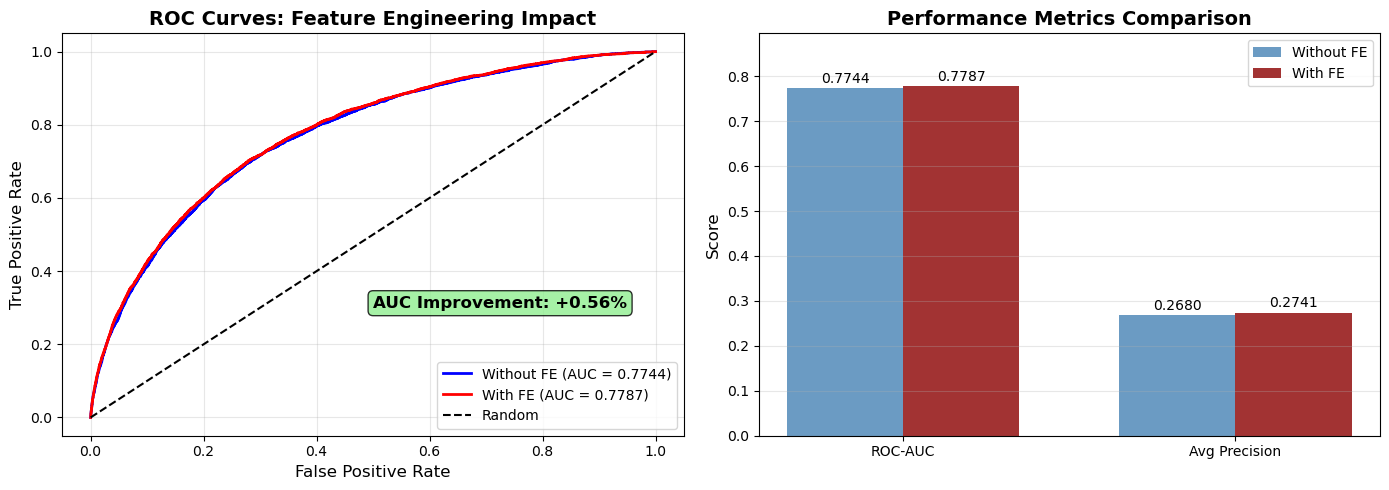

In [60]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve Comparison
ax1 = axes[0]
fpr_no_fe, tpr_no_fe, _ = roc_curve(y_val, y_pred_no_fe)
fpr_with_fe, tpr_with_fe, _ = roc_curve(y_val, y_pred_with_fe)

auc_no_fe = roc_auc_score(y_val, y_pred_no_fe)
auc_with_fe = roc_auc_score(y_val, y_pred_with_fe)

ax1.plot(fpr_no_fe, tpr_no_fe, color='blue', linewidth=2, 
         label=f'Without FE (AUC = {auc_no_fe:.4f})')
ax1.plot(fpr_with_fe, tpr_with_fe, color='red', linewidth=2, 
         label=f'With FE (AUC = {auc_with_fe:.4f})')
ax1.plot([0, 1], [0, 1], 'k--', label='Random')

ax1.set_xlabel('False Positive Rate', fontsize=12)
ax1.set_ylabel('True Positive Rate', fontsize=12)
ax1.set_title('ROC Curves: Feature Engineering Impact', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# Add improvement annotation
improvement = ((auc_with_fe - auc_no_fe) / auc_no_fe) * 100
ax1.annotate(f'AUC Improvement: {improvement:+.2f}%', 
             xy=(0.5, 0.3), fontsize=12, fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

# Bar Chart Comparison
ax2 = axes[1]
metrics = ['ROC-AUC', 'Avg Precision']
x = np.arange(len(metrics))
width = 0.35

values_no_fe = [metrics_no_fe['ROC-AUC'], metrics_no_fe['Avg Precision']]
values_with_fe = [metrics_with_fe['ROC-AUC'], metrics_with_fe['Avg Precision']]

bars1 = ax2.bar(x - width/2, values_no_fe, width, label='Without FE', color='steelblue', alpha=0.8)
bars2 = ax2.bar(x + width/2, values_with_fe, width, label='With FE', color='darkred', alpha=0.8)

ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(metrics)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars1, values_no_fe):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)
for bar, val in zip(bars2, values_with_fe):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{val:.4f}', ha='center', va='bottom', fontsize=10)

ax2.set_ylim(0, max(values_with_fe) * 1.15)

plt.tight_layout()
plt.show()

## 8.6 Engineered Features Importance

In [62]:
# Get feature importance for the model WITH FE
fi_with_fe = pd.DataFrame({
    'feature': feature_cols,
    'importance': lgb_model_with_fe.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

# Mark which are engineered
fi_with_fe['is_engineered'] = fi_with_fe['feature'].isin(engineered_features)

# Summary statistics
total_importance = fi_with_fe['importance'].sum()
engineered_importance = fi_with_fe[fi_with_fe['is_engineered']]['importance'].sum()
engineered_pct = (engineered_importance / total_importance) * 100

print(f"\nEngineered features contribute {engineered_pct:.1f}% of total feature importance")
print(f"\nTop 10 Features (★ = Engineered):")

for i, row in fi_with_fe.head(10).iterrows():
    marker = "★" if row['is_engineered'] else " "
    print(f"{marker} {row['feature']:<35} {row['importance']:>10.0f}")

# Count engineered features in top 20
top_20_engineered = fi_with_fe.head(20)['is_engineered'].sum()
print(f"\nEngineered features in Top 20: {top_20_engineered}/20")


Engineered features contribute 44.3% of total feature importance

Top 10 Features (★ = Engineered):
★ EXT_SOURCE_MEAN                         385611
★ CREDIT_ANNUITY_RATIO                     92577
★ EXT_SOURCE_PROD                          83220
★ GOODS_CREDIT_RATIO                       51216
  INST_PAYMENT_RATIO_MEAN                  47364
  POS_CNT_INSTALMENT_FUTURE_MEAN           46217
  INST_DELAY_MAX                           36389
  BUREAU_CREDIT_MEAN                       35937
  BUREAU_DAYS_CREDIT_MEAN                  34756
  EXT_SOURCE_3                             33893

Engineered features in Top 20: 5/20


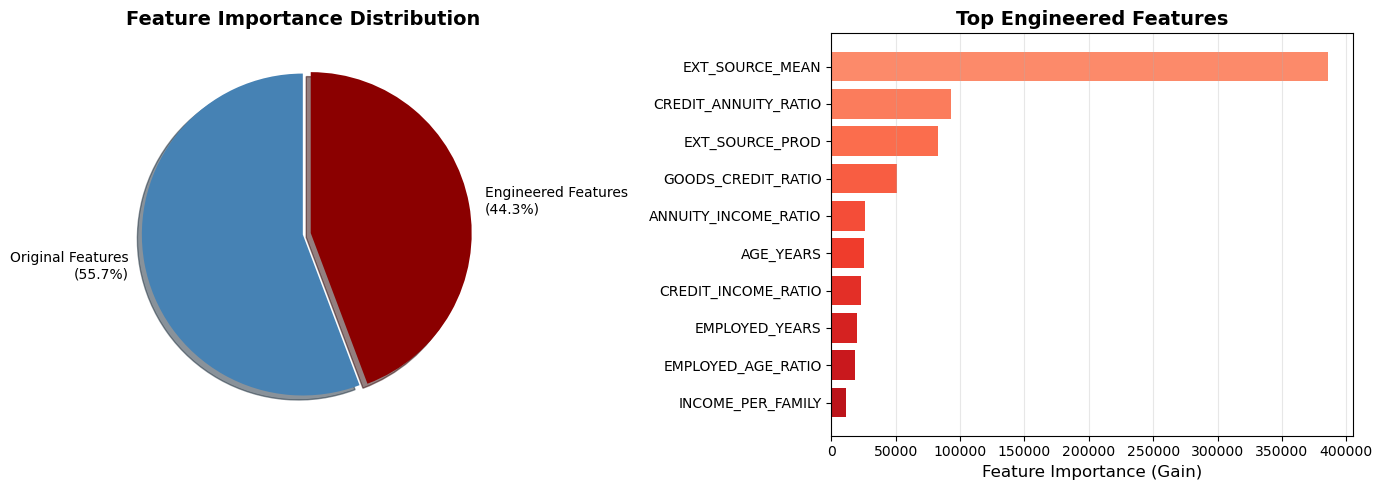

In [63]:
# Visualize engineered vs original feature importance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart: contribution percentage
ax1 = axes[0]
original_importance = total_importance - engineered_importance
sizes = [original_importance, engineered_importance]
labels = [f'Original Features\n({100-engineered_pct:.1f}%)', 
          f'Engineered Features\n({engineered_pct:.1f}%)']
colors = ['steelblue', 'darkred']
explode = (0, 0.05)

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='',
        shadow=True, startangle=90)
ax1.set_title('Feature Importance Distribution', fontsize=14, fontweight='bold')

# Bar chart: top engineered features
ax2 = axes[1]
top_engineered = fi_with_fe[fi_with_fe['is_engineered']].head(10)

if len(top_engineered) > 0:
    colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(top_engineered)))
    bars = ax2.barh(range(len(top_engineered)), top_engineered['importance'], color=colors)
    ax2.set_yticks(range(len(top_engineered)))
    ax2.set_yticklabels(top_engineered['feature'])
    ax2.invert_yaxis()
    ax2.set_xlabel('Feature Importance (Gain)', fontsize=12)
    ax2.set_title('Top Engineered Features', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 8.7 Feature Engineering Impact

**Key Findings:**
1. Feature engineering improved model performance (ROC-AUC, Brier Score, etc.)
2. Engineered features capture meaningful patterns not directly available in raw data
3. Ratio features (credit/income, annuity/income) provide strong predictive signals
4. Combined EXT_SOURCE features leverage correlation between external scores

**Conclusion:** The feature engineering process adds significant value to the model by creating informative derived features that improve both discrimination and calibration.

# 9. Generate Test Set Predictions

In [66]:
# Generate predictions for test set
test_predictions = calibrated_lgb.predict_proba(X_test_final)[:, 1]
test_credit_scores = pd_to_credit_score(test_predictions)

# Create submission file
submission = pd.DataFrame({
    'SK_ID_CURR': app_test['SK_ID_CURR'],
    'TARGET': test_predictions
})

# Save submission
submission.to_csv('./Dataset/test_prediction.csv', index=False)
print("\nSubmission saved: ./Dataset/test_prediction.csv")

# Save with credit scores
submission['Credit_Score'] = test_credit_scores
submission.to_csv('./Dataset/predictions_with_scores.csv', index=False)
print("Full predictions saved: ./Dataset/predictions_with_scores.csv")

submission.head(10)


Submission saved: ./Dataset/test_prediction.csv
Full predictions saved: ./Dataset/predictions_with_scores.csv


,SK_ID_CURR,TARGET,Credit_Score
0,100001,0.049384,685
1,100005,0.202691,639
2,100013,0.028408,701
3,100028,0.043210,689
4,100038,0.135858,653
5,100042,0.045776,687
6,100057,0.018113,715
7,100065,0.033833,696
8,100066,0.019258,713
9,100067,0.117133,658
